In [36]:
#  import libary
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
df = pd.read_csv("../../datasets/others/sunspot.csv", sep=";",header=None)
df.columns = ['year', 'month', 'day', 'decimal_date', 'total_sunspot_number', 'std_dev', 'num_observation', 'provisional_indicator']

In [38]:
df = df.assign(date=df.year.astype('string')+'-'+df.month.astype('string')+'-'+df.day.astype('string'))

In [39]:
df.index = pd.to_datetime(df.date)

In [40]:
df.head()

,year,month,day,decimal_date,total_sunspot_number,std_dev,num_observation,provisional_indicator,date
date,,,,,,,,,
1818-01-01,1818,1,1,1818.001,-1,-1.0,0,1,1818-1-1
1818-01-02,1818,1,2,1818.004,-1,-1.0,0,1,1818-1-2
1818-01-03,1818,1,3,1818.007,-1,-1.0,0,1,1818-1-3
1818-01-04,1818,1,4,1818.010,-1,-1.0,0,1,1818-1-4
1818-01-05,1818,1,5,1818.012,-1,-1.0,0,1,1818-1-5


In [41]:
df.drop(['year', 'month', 'day', 'date', 'decimal_date'], axis=1, inplace=True)

In [42]:
df.head()

,total_sunspot_number,std_dev,num_observation,provisional_indicator
date,,,,
1818-01-01,-1,-1.0,0,1
1818-01-02,-1,-1.0,0,1
1818-01-03,-1,-1.0,0,1
1818-01-04,-1,-1.0,0,1
1818-01-05,-1,-1.0,0,1


<AxesSubplot:>

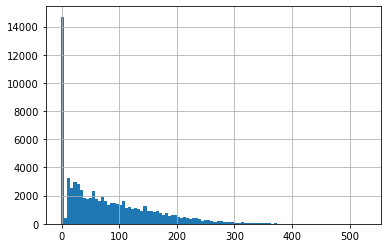

In [43]:
df.total_sunspot_number.hist(bins=100)

In [44]:
df.total_sunspot_number.value_counts()

 0      11347
-1       3247
 12      1319
 27       922
 23       921
        ...  
 484        1
 356        1
 463        1
 518        1
 335        1
Name: total_sunspot_number, Length: 438, dtype: int64

<AxesSubplot:xlabel='date'>

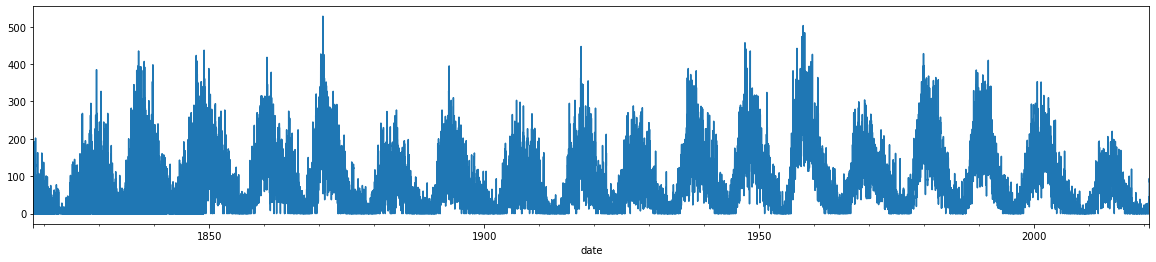

In [45]:
df.total_sunspot_number.plot(figsize=(20,4))

## Preprocessing

Total number of sunspot = -1 means that there are no calculation on that particular day.  We remove them and replace by value from the previous day.

In [66]:
df.total_sunspot_number = np.where((df.total_sunspot_number == -1), np.NAN, df.total_sunspot_number)
df.dropna(axis=0,inplace=True)
ts  = df.total_sunspot_number.asfreq(freq='d', method='bfill')

In [67]:
ts = ts.resample('M').sum()

<AxesSubplot:xlabel='date'>

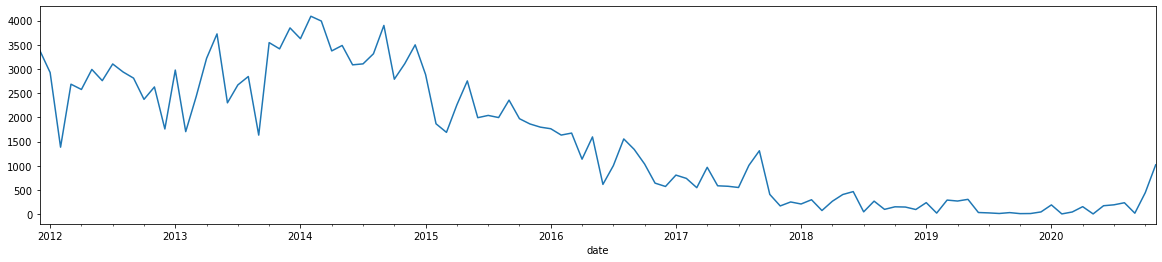

In [68]:
#last plot the data of the past nine years
ts[-12*9:].plot(figsize=(20,4))

The seasonality plot shows that there is seasonality in the data

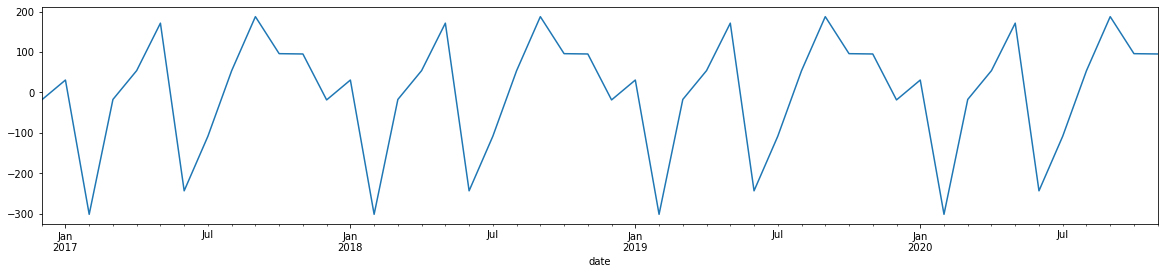

In [108]:
result = seasonal_decompose(ts, model='additive')
result.seasonal[-12*4:].plot(figsize=(20, 4))
plt.show()

## Train test split

Before we perform analysis on the data, let us split the data into training set and test set.

In [171]:
ts = ts['2008-01-01':]

In [172]:
train_set = ts[:'2019-11-01']
test_set = ts['2019-11-01':]

train_set_arr = train_set.values
test_set_arr = test_set.values

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range=(-1,1))
# scaler = StandardScaler()

scaler.fit(train_set_arr.reshape(-1,1))

train_norm = scaler.transform(train_set_arr.reshape((-1,1)))
test_norm = scaler.transform(test_set_arr.reshape((-1,1)))

## Dataset

In [173]:
from torch.utils.data import Dataset, DataLoader

class SunspotDataSet(Dataset):
    def __init__(self, data, input_window_size, num_future):
        self.data = torch.Tensor(data)
        self.input_window_size = input_window_size
        self.num_future = num_future
    
    def __len__(self):
        return len(self.data) - self.input_window_size - self.num_future
    
    def __getitem__(self, idx):
        X = self.data[idx:idx + self.input_window_size]
        y = self.data[idx+self.input_window_size:idx + self.input_window_size + self.num_future]
        return X,y

In [174]:
window_size = 21
num_futures = 3

train_ds = SunspotDataSet(data=train_norm, input_window_size = window_size, num_future = num_futures)
test_ds = SunspotDataSet(data=test_norm, input_window_size = window_size, num_future = num_futures)
batch_size = 14
train_loader = DataLoader(train_ds, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, drop_last=True)

## Building a Model

In [175]:
class EncoderRNN(nn.Module):
    
    def __init__(self, num_features, num_hidden, batch_size):
        super().__init__()
        self.input_size = num_features
        self.hidden_size = num_hidden
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size= self.input_size, hidden_size=self.hidden_size, batch_first=True)
        self.hidden = (torch.zeros(1,self.batch_size,self.hidden_size), torch.zeros(1,self.batch_size,self.hidden_size))
    
    def reset_hidden(self):
        self.hidden = (torch.zeros(1,self.batch_size,self.hidden_size), torch.zeros(1,self.batch_size,self.hidden_size))
        
    def forward(self, seq):
        seq = seq.view(self.batch_size,seq.shape[1], -1)
        out_lstm, hidden = self.lstm(seq, self.hidden)
        return out_lstm, hidden

class DecoderRNN(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, batch_size):
        super().__init__()
        self.hidden_size = num_hidden
        self.num_output = num_output
        self.input_size = num_features
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size= self.hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=num_output)
        
    def forward(self, seq, hidden):
        seq = seq.view(self.batch_size,seq.shape[1], -1)
        out_lstm, out_hidden = self.lstm(seq, hidden)
        out = self.linear(out_lstm.view(len(out_lstm), -1))
        return out, hidden

class Seq2Seq(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, num_futures, batch_size):
        super().__init__()
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.num_futures = num_futures
        self.batch_size = batch_size
        
        self.encoder = EncoderRNN(self.num_features, self.num_hidden, batch_size)
        self.decoder = DecoderRNN(self.num_features, self.num_hidden, self.num_output, batch_size)
        
    def reset_hidden(self):
        self.encoder.reset_hidden()
    
    def forward(self, seq, prev_y):
        encoder_out, encoder_hidden = self.encoder(seq)
        #placeholder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_out = prev_y
        prev_hidden = encoder_hidden
        
        for future_data in range(self.num_futures):
            decoder_out, decoder_hidden = self.decoder(prev_out, prev_hidden)
            prev_out = decoder_out
            prev_hidden = decoder_hidden
            targets_ta.append(prev_out.reshape(self.batch_size))
        
        targets = torch.stack(targets_ta, dim=1)
        return targets

## Model Training

In [176]:
num_features = 1
num_hidden = 50
num_output = 1


torch.manual_seed(42)

model = Seq2Seq(num_features, num_hidden, num_output, num_futures, batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 
epochs = 200

for e in range(epochs):
    losses = []
    for train_features,train_label in train_loader:
        optimizer.zero_grad()
        model.reset_hidden()
        input_features = [train_features[batch_idx][-1, :].item() for batch_idx in range(batch_size)]
        input_features = torch.FloatTensor(input_features).view(-1,1)
        seq_pred = model(train_features, input_features)
        loss = criterion(seq_pred, train_label.flatten().view(batch_size, num_futures))
        loss.backward()
        optimizer.step()
        losses.append(loss)
    print(f"Epoch {e} Loss: {loss.item()}")

Epoch 0 Loss: 0.721198558807373
Epoch 1 Loss: 0.6896824836730957
Epoch 2 Loss: 0.6503278017044067
Epoch 3 Loss: 0.6061899065971375
Epoch 4 Loss: 0.5556848049163818
Epoch 5 Loss: 0.4950625002384186
Epoch 6 Loss: 0.41812220215797424
Epoch 7 Loss: 0.3158700168132782
Epoch 8 Loss: 0.18097837269306183
Epoch 9 Loss: 0.044140346348285675
Epoch 10 Loss: 0.024128999561071396
Epoch 11 Loss: 0.0162162184715271
Epoch 12 Loss: 0.021652761846780777
Epoch 13 Loss: 0.022534172981977463
Epoch 14 Loss: 0.017666783183813095
Epoch 15 Loss: 0.017281783744692802
Epoch 16 Loss: 0.017648829147219658
Epoch 17 Loss: 0.017597177997231483
Epoch 18 Loss: 0.0178887490183115
Epoch 19 Loss: 0.01797705702483654
Epoch 20 Loss: 0.018133968114852905
Epoch 21 Loss: 0.018315371125936508
Epoch 22 Loss: 0.018472090363502502
Epoch 23 Loss: 0.018636014312505722
Epoch 24 Loss: 0.018785949796438217
Epoch 25 Loss: 0.018930817022919655
Epoch 26 Loss: 0.01906745694577694
Epoch 27 Loss: 0.01919778250157833
Epoch 28 Loss: 0.019321242

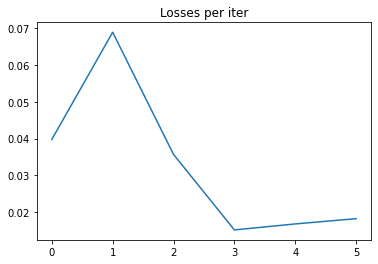

In [177]:
plt.title("Losses per iter")
plt.plot(losses)
plt.show()

In [178]:
torch.save(model.state_dict(), '../Trained_models/sunspot.pt')

In [179]:
test_batch_size = 1
model = Seq2Seq(num_features, num_hidden, num_output, num_futures, test_batch_size)
model.load_state_dict(torch.load('../Trained_models/sunspot.pt'))

<All keys matched successfully>

## Model Evaluation

In [180]:
train_norm = train_norm.flatten()
preds = train_norm[-window_size:].tolist()
model.eval()
futures = 12
test_batch = 1

for i in range(int(futures/num_futures)):
    seq = torch.FloatTensor(preds[-window_size:]).view(test_batch, len(preds[-window_size:]), 1)
    input_feature = seq[:,-1,:]
    with torch.no_grad():
        model.reset_hidden()
        predictions = model(seq, input_feature)
        preds += predictions.flatten().tolist()

In [181]:
#rescale back the data
true_preds = scaler.inverse_transform(np.array(preds[-futures:]).reshape(-1,1))

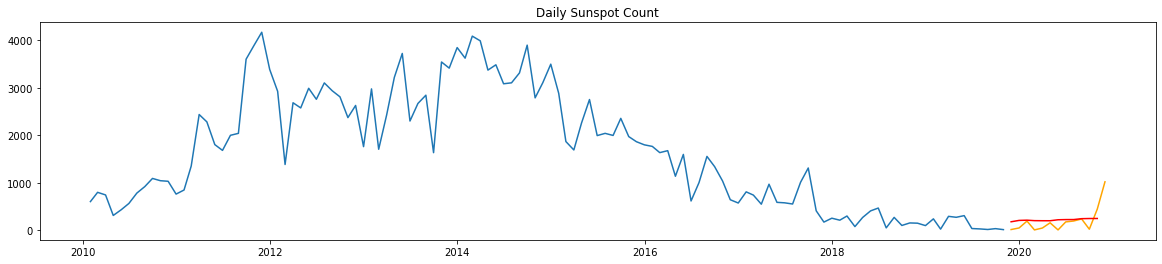

In [182]:
plt.figure(figsize=(20,4))
plt.title("Daily Sunspot Count")
plt.plot(train_set, label="Training")
plt.plot(test_set, label="Label", c="orange")
plt.plot(test_set.index[:-1], true_preds,  c="red")

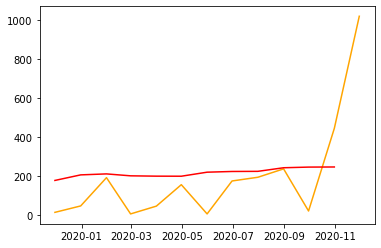

In [183]:
plt.plot(test_set, label="Label", c="orange")
plt.plot(test_set.index[:-1], true_preds,  c="red")